In [199]:
#General Necessities
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Linear Regression
from sklearn.linear_model import LinearRegression

#Generalized Additive Model
from pygam import LinearGAM
from sklearn import preprocessing

#Bayesian Neural Network
import torch
import torchbnn as bnn
from torch import nn
import torch.optim as optim

#Statistics
import statistics

# Load Data and Remove Unnecessary Columns & NA's

In [77]:
#Load in the data
fabricFilePath = "C:/Users/Nathan Mitchell/Downloads/weaving_rejection_dataset.csv"
fabric_full = pd.read_csv(fabricFilePath)

In [78]:
#Drop unnecessary columns & remove NA values
fabric_drop = fabric_full.drop(['Previous_pdn', "Construction", "warp_count"], axis = 'columns')
fabric = (fabric_drop.dropna())
fabric

,Req_Finish_Fabrics,Fabric_Allowance,Rec_Beam_length(yds),Shrink_allow,Req_grey_fabric,Req_beam_length(yds),Total_Pdn(yds),Rejection,weft_count,epi,ppi
0,31300.0,6.0,38286.9360,12.5,33297.872340,34797.651103,27646.0,285,80.0,110,80
1,10450.0,7.0,13057.5840,14.5,11236.559140,12017.350432,11019.0,39,40.0,110,90
2,900.0,11.5,1902.8640,12.5,1016.949153,1062.753843,1528.0,0,40.0,110,80
3,8000.0,8.0,10093.9280,14.0,8695.652174,9245.815159,8944.0,58,40.0,130,80
4,3500.0,8.1,69146.1408,9.1,3808.487486,3831.158751,59367.0,1043,50.0,140,70
...,...,...,...,...,...,...,...,...,...,...,...
22005,83449.0,7.0,98.4240,10.2,89730.107527,91369.942153,62.0,0,40.0,110,80
22006,83449.0,7.0,125.7640,10.2,89730.107527,91369.942153,105.0,0,40.0,92,70
22007,83449.0,7.0,131.2320,10.2,89730.107527,91369.942153,83.0,0,40.0,110,90
22008,83449.0,7.0,114.8280,10.2,89730.107527,91369.942153,93.0,0,50.0,110,80


### Set X and y

In [79]:
#Rename some columns for easier use later
fabric.rename(columns = {'Total_Pdn(yds)':'Total_Pdn', 
                         'Rec_Beam_length(yds)':'Rec_Beam_length'}, inplace = True)


#NEED COMMENTS HERE
#X_unscaled_rej = fabric.drop(["Total_Pdn"], axis = 1)
scale = preprocessing.StandardScaler().fit(fabric)
X = pd.DataFrame(scale.transform(fabric))
X.columns = fabric.columns

#Set the 'y' variables to be the Total Production and Rejection amounts
y = fabric.loc[:, ["Total_Pdn", "Rejection"]]

# Initial Data Exploration

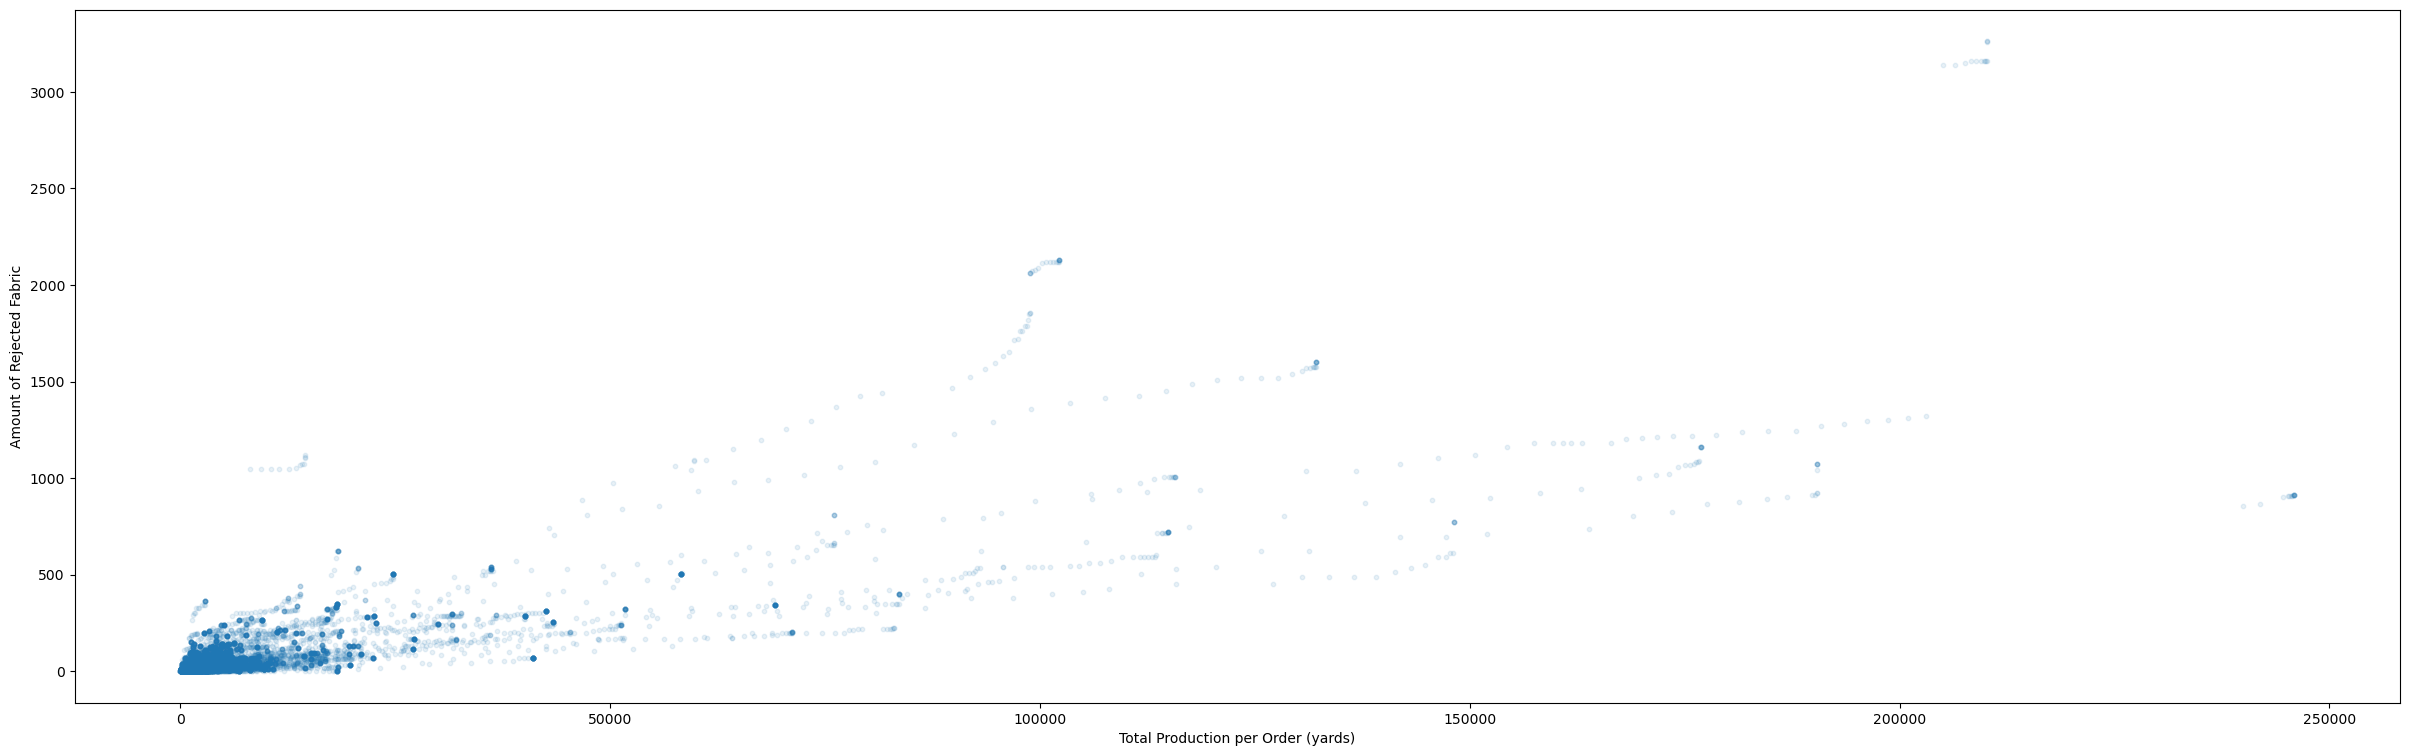

In [80]:
#Plot our two 'y' varibles against one another
plt.scatter(fabric['Total_Pdn'], fabric['Rejection'], s = 10, alpha = 0.1)
plt.xlabel("Total Production per Order (yards)")
plt.ylabel("Amount of Rejected Fabric")
plt.show()

In [81]:
#Test for a linear relationship between the two 'y' variables, how strong is it?
lr_pdn_rej = LinearRegression().fit(np.array(y['Total_Pdn']).reshape(-1,1), np.array(y['Rejection']).reshape(-1,1))

#Print out the R-squared
print("R^2: ", round(lr_pdn_rej.score(np.array(y['Total_Pdn']).reshape(-1,1), np.array(y['Rejection']).reshape(-1,1)), 3))

R^2:  0.666


# Model Fitting:

### Randomly Generate Training and Testing set

In [122]:
#Randomly generate training and testing datasets (75%, 25% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 460)

#Create 'X' training/testing sets for each of two outcome variables
X_train_pdn = X_train.drop(["Total_Pdn"], axis = 1)
X_train_rej = X_train.drop(["Rejection"], axis = 1)

X_test_pdn = X_test.drop(["Total_Pdn"], axis = 1)
X_test_rej = X_test.drop(["Rejection"], axis = 1)

#Create 'y' training/testing sets for each of two outcome variables
y_train_pdn = y_train['Total_Pdn']
y_train_rej = y_train['Rejection']

y_test_pdn = y_test['Total_Pdn']
y_test_rej = y_test['Rejection']

## Linear Models:

### Multiple Linear Regression:

In [162]:
#Fit two Linear Regression models, one on each of the two outcome variables
lr_pdn = LinearRegression().fit(X_train_pdn, y_train_pdn)
lr_rej = LinearRegression().fit(X_train_rej, y_train_rej)

#Print the R-squared associated with each model
print("Producition R-Squared: ", round(lr_pdn.score(X_train_pdn, y_train_pdn), 3))
print("Rejection R-Squared:   ", round(lr_rej.score(X_train_rej, y_train_rej), 3))

Producition R-Squared:  0.963
Rejection R-Squared:    0.675


#### RMSE:

In [163]:
#Print the testing Root Mean Squared Error (RMSE) for each model (in the original units).
print("Production Model RMSE: ", round(math.sqrt((np.sum(np.square((y_test_pdn - lr_pdn.predict(X_test_pdn)))))/len(X_test_pdn)), 3))
print("Rejection Model RMSE:  ", round(math.sqrt((np.sum(np.square((y_test_rej - lr_rej.predict(X_test_rej)))))/len(X_test_rej)), 3))

Production Model RMSE:  3540.306
Rejection Model RMSE:   88.951


In [164]:
#Print the Standard Deviation of each outcome variable (for RMSE comparison purposes).
print("Production Standard Deviation: ", round(statistics.stdev(y_test_pdn), 3))
print("Rejection Standard Deviation:  ", round(statistics.stdev(y_test_rej), 3))

Production Standard Deviation:  18933.823
Rejection Standard Deviation:   155.654


In [165]:
#Print the tesing RMSE of each model (in standardized units -- the closer to 0 the better!).
print("Production Model RMSE/s: ",round(math.sqrt((np.sum(np.square((y_test_pdn - lr_pdn.predict(X_test_pdn)))))/len(X_test_pdn))/statistics.stdev(y_test_pdn),3))
print("Rejection Model RMSE/s:  ",round(math.sqrt((np.sum(np.square((y_test_rej - lr_rej.predict(X_test_rej)))))/len(X_test_rej))/statistics.stdev(y_test_rej),3))

Production Model RMSE/s:  0.187
Rejection Model RMSE/s:   0.571


### Generalized Additive Model (GAM):

In [107]:
#Fit two base GAMs, one for each outcome variable.
gam_pdn = LinearGAM().fit(np.array(X_train_pdn), y_train_pdn)
gam_rej = LinearGAM().fit(np.array(X_train_rej), y_train_rej)

In [26]:
#Print the lambda values associated with each model.
print(getattr(gam_pdn, "lam", None))
print(getattr(gam_rej, "lam", None))

[[0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6]]
[[0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6], [0.6]]


#### RMSE:

In [27]:
#Print the RMSE (in original units) for each outcome variable.
print("Production Model RMSE: ", round(math.sqrt((np.sum(np.square((y_test_pdn - gam_pdn.predict(X_test_pdn)))))/len(X_test_pdn)), 3))
print("Rejection Model RMSE:  ", round(math.sqrt((np.sum(np.square((y_test_rej - gam_rej.predict(X_test_rej)))))/len(X_test_rej)), 3))

Production Model RMSE:  3214.998
Rejection Model RMSE:   68.164


In [29]:
#Print the RMSE (in standardized units) for each otucome variable.
print("Production Model RMSE/s: ", round(math.sqrt((np.sum(np.square((y_test_pdn - gam_pdn.predict(X_test_pdn)))))/len(X_test_pdn))/statistics.stdev(y_test_pdn),3))
print("Rejection Model RMSE/s:  ", round(math.sqrt((np.sum(np.square((y_test_rej - gam_rej.predict(X_test_rej)))))/len(X_test_rej))/statistics.stdev(y_test_rej),3))

Production Model RMSE/s:  0.17
Rejection Model RMSE/s:   0.438


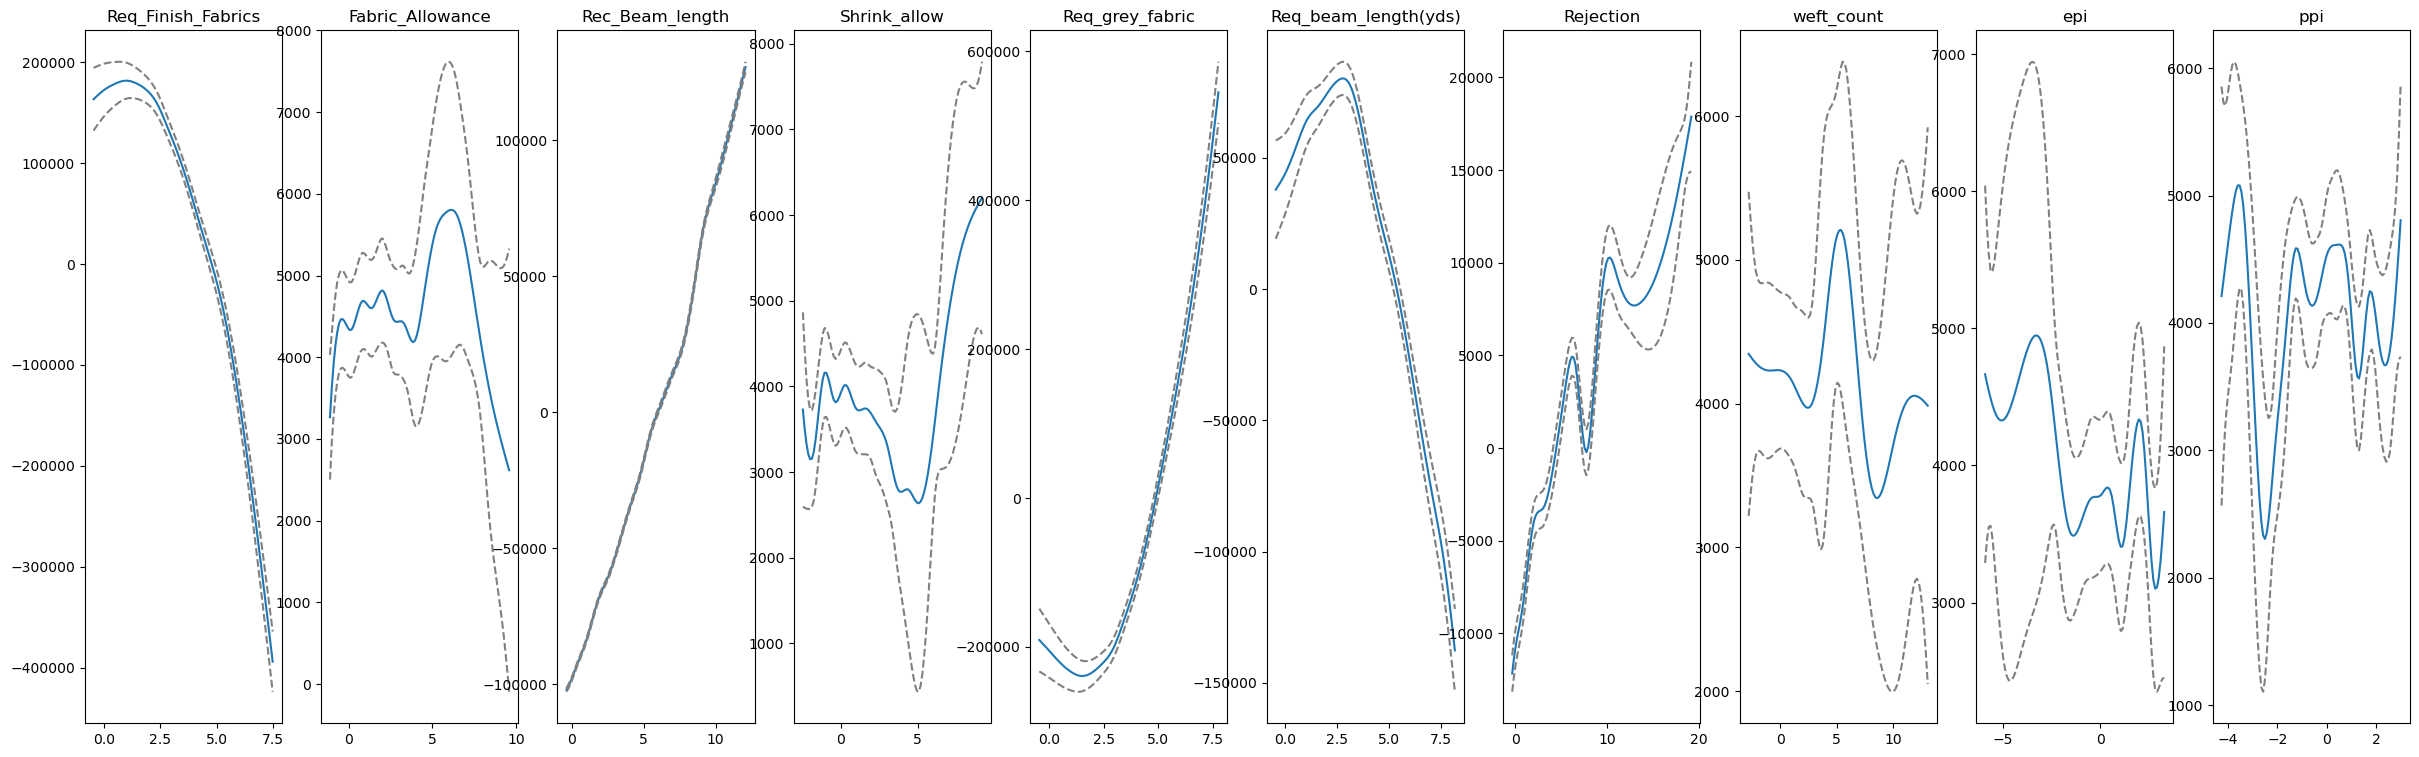

In [31]:
#Create a figure with 9 sublpots & title them
plt.rcParams['figure.figsize'] = (30, 9)
fig, ax = plt.subplots(1, len(X_train_pdn.columns))
titles = X_train_pdn.columns

#For all the subplots...
for i in range(len(titles)):
    #Generate the grid of X values for the ith model
    XX = gam_pdn.generate_X_grid(term = i)
    
    #Generate the y values and the error bars for each model (95% confidence level)
    pdep, confi = gam_pdn.partial_dependence(term = i, X = XX, width = 0.95)
    
    #Plot what we've calculated -- the error bars are in gray
    ax[i].plot(XX[:, i], pdep)
    ax[i].plot(XX[:, i], confi[:, 0], c='grey', ls='--')
    ax[i].plot(XX[:, i], confi[:, 1], c='grey', ls='--')
    ax[i].set_title(titles[i])
    
plt.show()

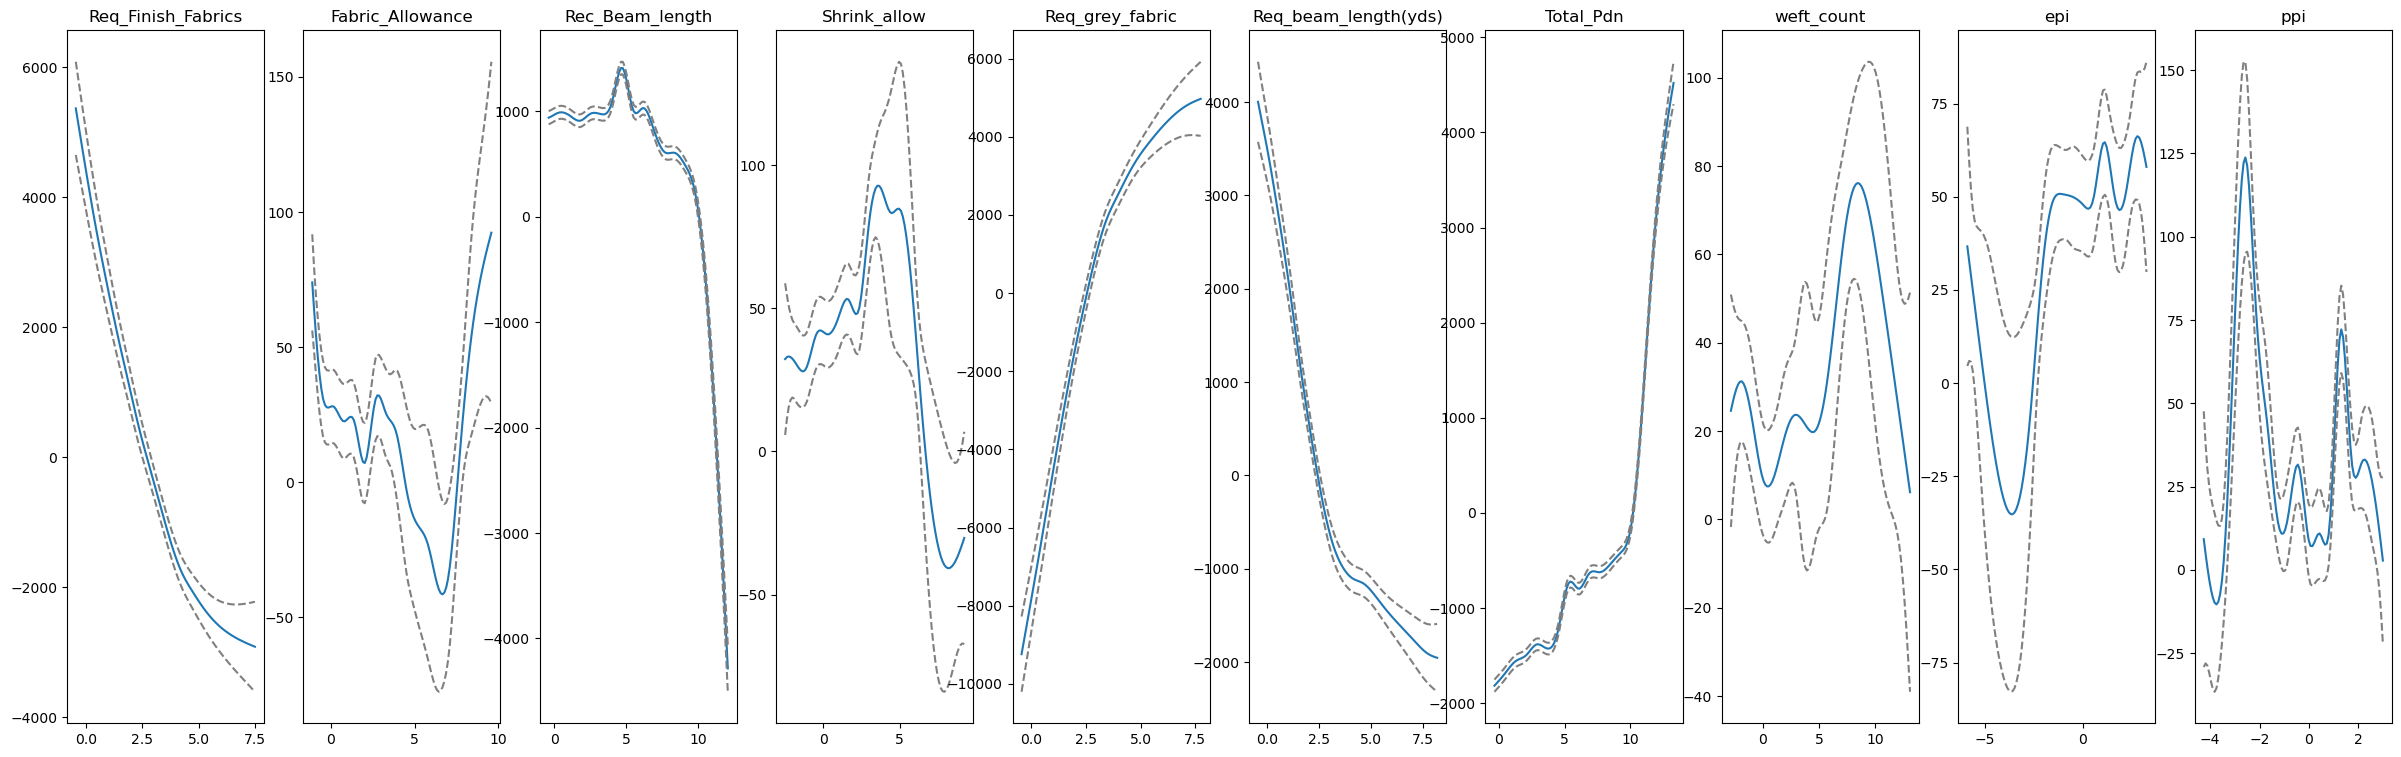

In [32]:
#Create a figure with 9 sublpots & title them
plt.rcParams['figure.figsize'] = (30, 9)
fig, ax = plt.subplots(1, len(X_train_rej.columns))
titles = X_train_rej.columns

#For all the subplots...
for i in range(len(titles)):
    #Generate the grid of X values for the ith model
    XX = gam_rej.generate_X_grid(term = i)
    
    #Generate the y values and the error bars for each model (95% confidence level)
    pdep, confi = gam_rej.partial_dependence(term = i, X = XX, width = 0.95)
    
    #Plot what we've calculated -- the error bars are in gray
    ax[i].plot(XX[:, i], pdep)
    ax[i].plot(XX[:, i], confi[:, 0], c='grey', ls='--')
    ax[i].plot(XX[:, i], confi[:, 1], c='grey', ls='--')
    ax[i].set_title(titles[i])
    
plt.show()

In [36]:
#Create the lambda values for our next GAM
lam = np.logspace(-6, 0, 3)
lams = [lam] * 10
lams

[array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00]),
 array([1.e-06, 1.e-03, 1.e+00])]

In [37]:
#Fit the GAM to our Production outcome vairable with the above lambda values.
#A search will be performed for the best combination.
gam_pdn_gs = LinearGAM().gridsearch(np.array(X_train_pdn), y_train_pdn, lam = lams)

100% (59049 of 59049) |#################| Elapsed Time: 15:19:55 Time: 15:19:553004


In [42]:
#Fit the GAM to our Rejection outcome vairable with the above lambda values.
#A search will be performed for the best combination.
gam_rej_gs = LinearGAM().gridsearch(np.array(X_train_rej), y_train_rej, lam = lams)

In [43]:
#Print the new, optimal combination of lambda values
print(getattr(gam_pdn_gs, "lam", None))
#print(getattr(gam_rej_gs, "lam", None))

[[1e-06], [1.0], [1e-06], [1.0], [1e-06], [1e-06], [0.001], [1.0], [1e-06], [1.0]]


In [200]:
#Print the RMSE (in original units) for each outcome variable.
print("Production Model RMSE: ", round(math.sqrt((np.sum(np.square((y_test_pdn - gam_pdn_gs.predict(X_test_pdn)))))/len(X_test_pdn)), 3))
print("Rejection Model RMSE:  ", 66.027)
#print("Rejection Model RMSE:  ", round(math.sqrt((np.sum(np.square((y_test_rej - gam_rej_gs.predict(X_test_rej)))))/len(X_test_rej)), 3))

Production Model RMSE:  3067.677
Rejection Model RMSE:   66.027


In [201]:
#Print the RMSE (in standardized units) for each outcome variable.
print("Production Model RMSE/s: ", round(math.sqrt((np.sum(np.square((y_test_pdn - gam_pdn_gs.predict(X_test_pdn)))))/len(X_test_pdn))/statistics.stdev(y_test_pdn),3))
print("Rejection Model RMSE/s:  ", 0.424)
#print("Rejection Model RMSE/s:  ", round(math.sqrt((np.sum(np.square((y_test_rej - gam_rej_gs.predict(X_test_rej)))))/len(X_test_rej))/statistics.stdev(y_test_rej),3))

Production Model RMSE/s:  0.162
Rejection Model RMSE/s:   0.424


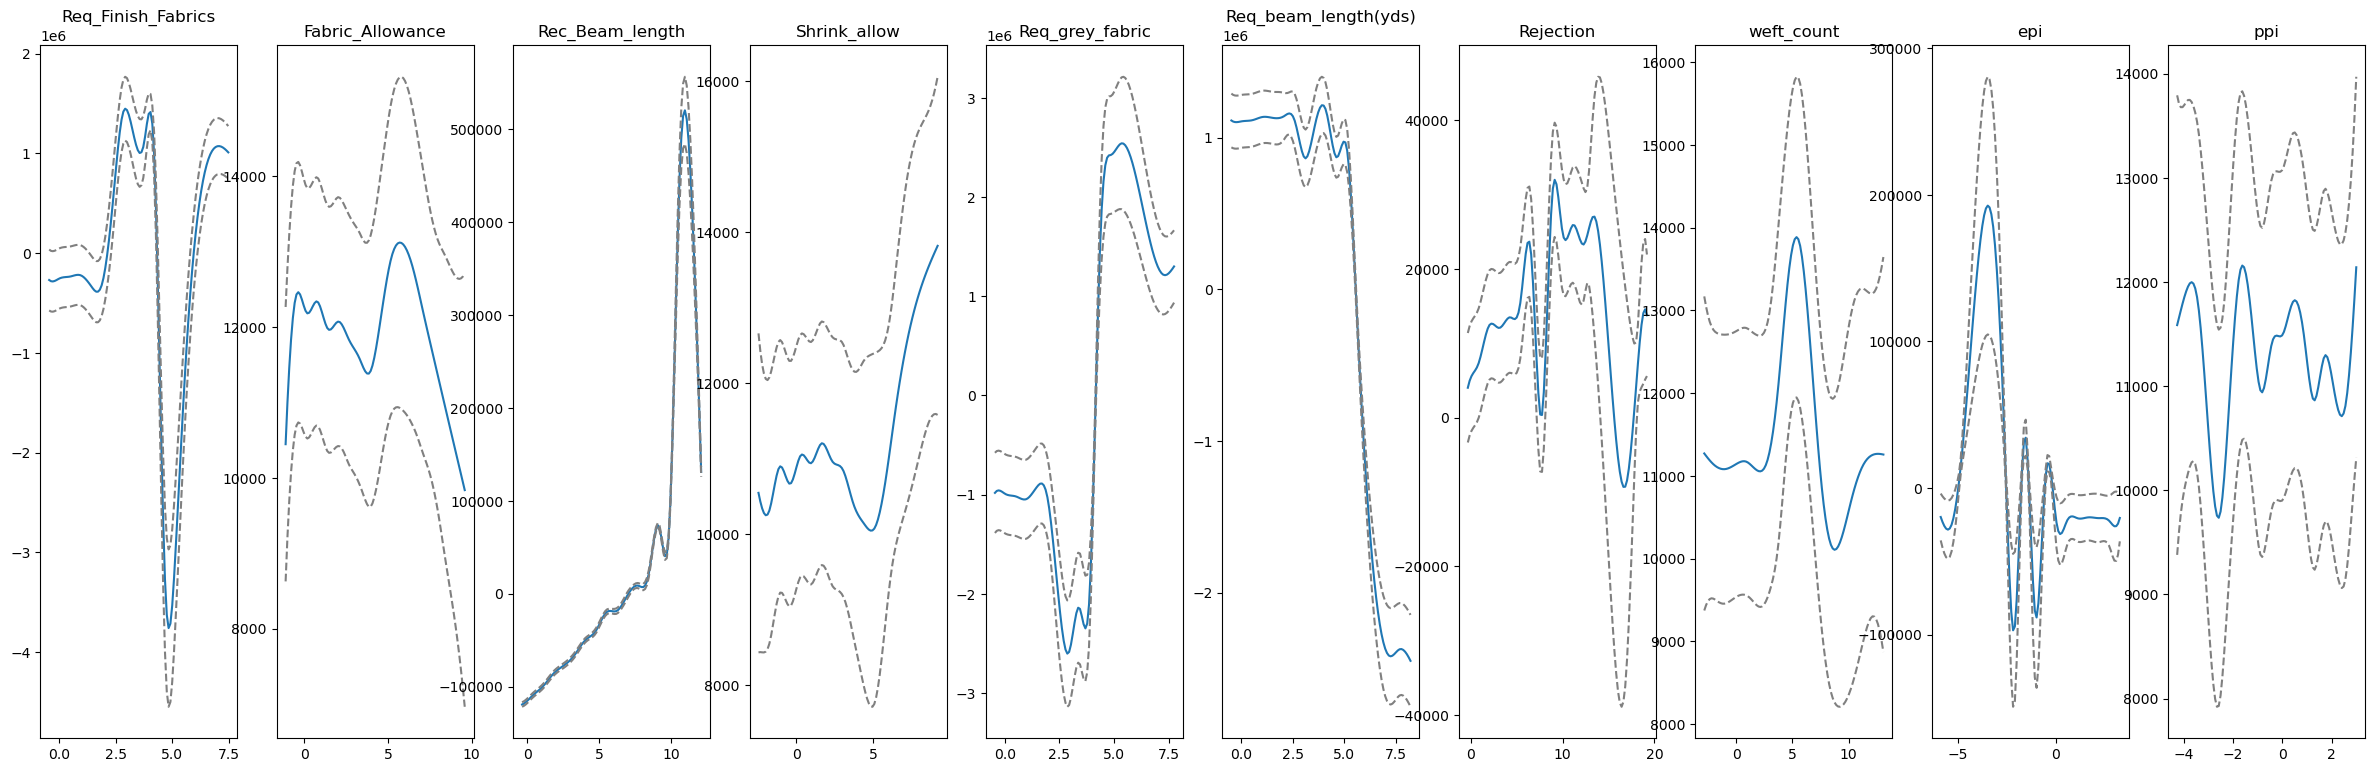

In [41]:
#Create a figure with 9 sublpots & title them
plt.rcParams['figure.figsize'] = (30, 9)
fig, ax = plt.subplots(1, len(X_train_pdn.columns))
titles = X_train_pdn.columns

#For all the subplots...
for i in range(len(titles)):
    #Generate the grid of X values for the ith model
    XX = gam_pdn_gs.generate_X_grid(term = i)
    
    #Generate the y values and the error bars for each model (95% confidence level)
    pdep, confi = gam_pdn_gs.partial_dependence(term = i, X = XX, width = 0.95)

    #Plot what we've calculated -- the error bars are in gray
    ax[i].plot(XX[:, i], pdep)
    ax[i].plot(XX[:, i], confi[:, 0], c='grey', ls='--')
    ax[i].plot(XX[:, i], confi[:, 1], c='grey', ls='--')
    ax[i].set_title(titles[i])
    
plt.show()

In [ ]:
#Create a figure with 9 sublpots & title them
plt.rcParams['figure.figsize'] = (30, 9)
fig, ax = plt.subplots(1, len(X_train_rej.columns))
titles = X_train_rej.columns

#For all the subplots...
for i in range(len(titles)):
    #Generate the grid of X values for the ith model
    XX = gam_rej_gs.generate_X_grid(term = i)
    
    #Generate the y values and the error bars for each model (95% confidence level)
    pdep, confi = gam_rej_gs.partial_dependence(term = i, X = XX, width = 0.95)
    
    #Plot what we've calculated -- the error bars are in gray
    ax[i].plot(XX[:, i], pdep)
    ax[i].plot(XX[:, i], confi[:, 0], c='grey', ls='--')
    ax[i].plot(XX[:, i], confi[:, 1], c='grey', ls='--')
    ax[i].set_title(titles[i])
    
plt.show()

## Non-Linear Models:

### Bayesian Neural Network:

In [61]:
#Change X and y into float tensors -- necessary to fit the model
X_train_tensor = torch.FloatTensor(X_train_pdn.values)
y_train_tensor = torch.FloatTensor(y_train_pdn.values).reshape(-1,1)

X_test_tensor  = torch.FloatTensor(X_test_pdn.values)
y_test_tensor  = torch.FloatTensor(y_test_pdn.values)

In [62]:
#Initialize Two-Layer Feed-Forward Neural Network with Bayesian Layers
model = nn.Sequential(bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 16507),
                      nn.LeakyReLU(), #Leaky ReLu Activation Function
                      bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 16507, out_features = 1),)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train the model based on MSE
for step in range(4000):
    pre = model(X_train_tensor)
    mse = mse_loss(pre, y_train_tensor)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

In [63]:
#Standardized Training RMSE
math.sqrt(mse.item())/math.sqrt(np.sum(np.square(y_train_pdn - np.mean(y_train_pdn))/(len(y_train_pdn) - 1)))

0.16574735265215065

In [64]:
#Predict the outcome 1000 times
results = np.array([model(X_test_tensor).data.numpy() for k in range(1000)])

#Reshape the results
results_reshaped = results[:,:,0].T

#Calculate the mean of every individual response
means = np.array([np.mean(results_reshaped[i]) for i in range(len(results_reshaped))])

#Get the standard deviation of each response (from the 1000 predicted values)
standard_deviations = np.array([results_reshaped[i].std() for i in range(len(results_reshaped))])

In [65]:
upper_bounds = []
lower_bounds = []

y_train_rej = np.array(y_train_rej)

#Create estimates for our upper and lower bounds by using the standard deviation
for i in range(len(y_test_rej)):
    if(means[i] >= y_train_rej[i]):
        upper_bounds.append(means[i] + standard_deviations[i])
        lower_bounds.append(means[i] - standard_deviations[i])
    else:
        upper_bounds.append(means[i] - standard_deviations[i])
        lower_bounds.append(means[i] + standard_deviations[i])

In [196]:
#Print the RMSE for our mean estimate and upper/lower bounds
print("Production Model Lower Bound RMSE: ", round(math.sqrt((np.sum(np.square((lower_bounds - y_test_pdn))))/len(y_test)), 3))
print("Production Model Mean RMSE:        ", round(math.sqrt((np.sum(np.square((means - y_test_pdn))))/len(y_test)), 3))
print("Producion Model Upper Bound RMSE:  ", round(math.sqrt((np.sum(np.square((upper_bounds - y_test_pdn))))/len(y_test)), 3))

Production Model Lower Bound RMSE:  3075.191
Production Model Mean RMSE:         3074.998
Producion Model Upper Bound RMSE:   3075.152


In [195]:
#Print the RMSE (in standardized units) for our mean estimate and upper/lower bounds
print("Production Model Lower Bound RMSE: ", round(math.sqrt((np.sum(np.square((lower_bounds - y_test_pdn))))/len(y_test))/statistics.stdev(y_test_pdn), 3))
print("Production Model Mean RMSE:        ", round(math.sqrt((np.sum(np.square((means - y_test_pdn))))/len(y_test))/statistics.stdev(y_test_pdn), 3))
print("Producion Model Upper Bound RMSE:  ", round(math.sqrt((np.sum(np.square((upper_bounds - y_test_pdn))))/len(y_test))/statistics.stdev(y_test_pdn), 3))

Production Model Lower Bound RMSE:  0.162
Production Model Mean RMSE:         0.162
Producion Model Upper Bound RMSE:   0.162


In [51]:
#Change X and y into float tensors -- necessary to fit the model
X_train_tensor = torch.FloatTensor(X_train_rej.values)
y_train_tensor = torch.FloatTensor(y_train_rej.values).reshape(-1,1)

X_test_tensor  = torch.FloatTensor(X_test_rej.values)
y_test_tensor  = torch.FloatTensor(y_test_rej.values)

In [52]:
#Initialize Two-Layer Feed-Forward Neural Network with Bayesian Layers
model = nn.Sequential(bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 10, out_features = 16507),
                      nn.LeakyReLU(), #Leaky ReLu Activation Function
                      bnn.BayesLinear(prior_mu = 0, prior_sigma = 0.1, in_features = 16507, out_features = 1),)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train the model based on MSE
for step in range(4000):
    pre = model(X_train_tensor)
    mse = mse_loss(pre, y_train_tensor)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

In [57]:
#Standardized Training RMSE
math.sqrt(mse.item())/math.sqrt(np.sum(np.square(y_train_rej - np.mean(y_train_rej))/(len(y_train_rej) - 1)))

0.4137370829630734

In [58]:
#Predict the outcome 1000 times
results = np.array([model(X_test_tensor).data.numpy() for k in range(1000)])

#Reshape the results
results_reshaped = results[:,:,0].T

#Calculate the mean of every individual response
means = np.array([np.mean(results_reshaped[i]) for i in range(len(results_reshaped))])

#Get the standard deviation of each response (from the 1000 predicted values)
standard_deviations = np.array([results_reshaped[i].std() for i in range(len(results_reshaped))])

In [59]:
upper_bounds = []
lower_bounds = []

y_train_rej = np.array(y_train_rej)

#Create estimates for our upper and lower bounds by using the standard deviation
for i in range(len(y_test_rej)):
    if(means[i] >= y_train_rej[i]):
        upper_bounds.append(means[i] + standard_deviations[i])
        lower_bounds.append(means[i] - standard_deviations[i])
    else:
        upper_bounds.append(means[i] - standard_deviations[i])
        lower_bounds.append(means[i] + standard_deviations[i])

In [60]:
#Print the RMSE (in standardized units) for our mean estimate and upper/lower bounds
print("Rejection Model Lower Bound RMSE: ", round(math.sqrt((np.sum(np.square((lower_bounds - y_test_rej))))/len(y_test))/statistics.stdev(y_test_rej), 3))
print("Rejection Model Mean RMSE:        ", round(math.sqrt((np.sum(np.square((means - y_test_rej))))/len(y_test))/statistics.stdev(y_test_rej), 3))
print("Rejection Model Upper Bound RMSE: ", round(math.sqrt((np.sum(np.square((upper_bounds - y_test_rej))))/len(y_test))/statistics.stdev(y_test_rej), 3))

Rejection Model Lower Bound RMSE:  0.399
Rejection Model Mean RMSE:         0.401
Rejection Model Upper Bound RMSE:  0.412
